In [1]:
###########
# PRELUDE #
###########

# auto-reload changed python files
%load_ext autoreload
%autoreload 2

# Format cells with %%black
%load_ext blackcellmagic

# nice interactive plots
%matplotlib inline

import matplotlib
# enable more math expressions in matplotlib labels
matplotlib.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
# no blurry plots!
%config InlineBackend.figure_format = 'retina'

# add repository directory to include path
from pathlib import Path
import sys
PROJECT_DIR = Path('../..').resolve()
sys.path.append(str(PROJECT_DIR))

import inspect
def _acceptable_global(name, value):
    """Returns True if a global variable with name/value can be safely ignored"""
    return (
        # stuff that's normal to share everywhere
        inspect.isroutine(value) or
        inspect.isclass(value) or
        inspect.ismodule(value) or
        # leading underscore marks private variables
        name.startswith('_') or
        # all-caps names indicate constants
        name.upper() == name or
        # ignore IPython stuff
        name in {'In', 'Out'} or 
        getattr(value, '__module__', '').startswith('IPython'))

def assert_globals_clean():
    """Raises an assertion error if there are unmanaged global variables.
       Variables that are considered 'managed' include those formatted with 
       ALL_CAPS (constants), _a_leading_underscore (recognized as a global but at
       least indicated as private to the cell), classes and modules, automatic
       imports from IPython, and functions generally."""
    unmanaged_globals = {k:type(v) for k, v in globals().items() if not _acceptable_global(k, v)}
    if unmanaged_globals != {}:
        raise AssertionError(f"Unmanaged globals found: {unmanaged_globals}")
    ok("No unmanaged globals detected")

from IPython.display import display, Markdown, HTML

def markdown(s):
    return display(Markdown(s))

def html(s):
    return display(HTML(s))

def ok(message="OK"):
    html(f"<div class=\"alert alert-block alert-success\">{message}</div>")

html("""
<style>
.custom-assignment-text {
    background-color: lightyellow;
    border: 1px solid darkkhaki; 
    padding: 10px;
    border-radius: 2px
}
</style>""")

# Fixes space left behind tqdm progress bars with leave=False
# see https://github.com/jupyterlab/jupyterlab/issues/7354
html("""
<style>
.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

def display_table(data, title, headers):
    """Display data in an HTML table inline in the notebook
       data: list of lists of values to put in table rows
       title: to set table caption
       headers: list of table header strings"""
    text = "<table>"
    text += f"<caption style='font-weight: bold; font-size: large'>{title}</caption>"
    
    text += "<tr>"
    for h in headers:
        text += f'<th style="text-align:center">{h}</th>'
    text += "</tr>"
    
    for row in data:
        text += "<tr>"
        for value in row:
            text += f"<td>{value}</td>"
        text += "</tr>"
    text += "</table>"
    html(text)

markdown("#### Custom functionality enabled:")
markdown("* Format a code cell by entering `%%black` at the top of it")
markdown("* Surround markdown cells with  `<div class=\"custom-assignment-text\">\\n\\n ... \\n\\n</div>` to format course-provided assignment text")
markdown("* Use `ok(<message>)` to notify of a passing test")
markdown("* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)")
markdown("* Use `display_table` to display data in an inline HTML table")

#### Custom functionality enabled:

* Format a code cell by entering `%%black` at the top of it

* Surround markdown cells with  `<div class="custom-assignment-text">\n\n ... \n\n</div>` to format course-provided assignment text

* Use `ok(<message>)` to notify of a passing test

* Use `assert_globals_clean()` to check that all globals are managed (private, constants, etc.)

* Use `display_table` to display data in an inline HTML table

<div class="custom-assignment-text">

# Part 1: Spectral Methods Intuition

## Goal

In this exercise you will build some intuition for the eigenvectors of various simple graphs.

</div>

In [77]:
from matplotlib import pyplot as plt
import numpy as np
from numpy.testing import assert_approx_equal

<div class="custom-assignment-text">
    
## Description

(a) (6 points) Consider the graphs as given in Figure 1. For this part, take $n = 6$. For each graph write down the Laplacian matrix $L = D −A$ where $D$ is the diagonal matrix with entry $D_{i,j}$ being the degree of the $i$th node, and $A$ is the adjacency matrix, with entry $A_{i,j} = 1$ if there is an edge between nodes $i$ and $j$, and $A_{i,j} = 0$ otherwise. Your answer should be in the form of actual matrices (i.e., not just English descriptions of matrices).
    
<figure><center><img src="../../materials/Week 6/Figure_1.png" width=100%><figcaption>Figure 1: The graphs for question 1a.</figcaption></center></figure>

</div>

In [72]:
class Graph():
    def __init__(self, n):
        self.n = n
        self.D = np.zeros((n, n))
        self.A = np.zeros((n, n))
        
    def add_edge(self, i, j, weight=1):
        self.D[i,i] += weight
        self.D[j,j] += weight
        self.A[i,j] += weight
        self.A[j,i] += weight
        
    def get_laplacian(self):
        return self.D - self.A
    
    def conductance(self, S):
        """Given a subset of nodes S in V, the conductance is the sum of the edges between members
        of S and V\S, normalized by either the total edges of members of S or of V\S, whichever number
        is smaller."""
        
        A = self.D.diagonal()
        V_no_S = np.setdiff1d(np.arange(len(A)), S)
        
        A_s_to_v_no_s = 0
        for s in S:
            for vns in V_no_S:
                A_s_to_v_no_s += self.A[s, vns]

        A_s = A[S].sum()
        A_v_no_s = A[V_no_S].sum()
        
        return A_s_to_v_no_s / min(A_s, A_v_no_s)

In [73]:
def line_graph(n=6):
    graph = Graph(n)
    for i in range(n-1):
        graph.add_edge(i, i+1)
    return graph

def line_with_point_graph(n=6):
    graph = line_graph(n)
    for i in range(n-2):
        graph.add_edge(i, n-1)
    return graph

def circle_graph(n=6):
    graph = line_graph(n)
    # close the circle
    graph.add_edge(0, n-1)
    return graph

def circle_with_point_graph(n=6):
    graph = line_graph(n)
    # close the circle
    graph.add_edge(0, n-2)
    # connect points to center (n-2 is already connected to n-1)
    for i in range(0, n-2):
        graph.add_edge(i, n-1)
    return graph
    

def _test_graphs(graph_constructors):
    for name, f in graph_constructors.items():
        n = 100
        matrix = f(n).get_laplacian()
        assert matrix.shape == (n,n), f'{name}: {matrix.shape}'
        # graph should be symmetric
        assert np.allclose(matrix, matrix.T)
        # diagonal should be non-negative, others non-positive
        for i in range(n):
            for j in range(n):
                if i == j:
                    assert matrix[i,j] >= 0, f'{name}: {matrix[i,j]}'
                else:
                    assert matrix[i,j] <= 0, f'{name}: {matrix[i,j]}'
        
GRAPHERS = {"(a) Line graph": line_graph, "(b) Line graph with added point": line_with_point_graph, "(c) Circle graph": circle_graph, "(d) Circle graph with added point": circle_with_point_graph}        
_test_graphs(GRAPHERS)
ok()

In [80]:
def _test_conductance():
    # example from problem set: Circle graph with n (multiple of 2) vertices;
    # subset of n/2 consecutive vertices;
    # conductance should be 2/n
    n = 50
    g = circle_graph(n)
    S = range(int(n/2))
    assert_approx_equal(g.conductance(S), 2/n)
    
    ok()
    
_test_conductance()

In [5]:
for label, grapher in GRAPHERS.items():
    markdown(f'#### {label}')
    print(grapher().get_laplacian())

#### (a) Line graph

[[ 1. -1.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0. -1.  1.]]


#### (b) Line graph with added point

[[ 2. -1.  0.  0.  0. -1.]
 [-1.  3. -1.  0.  0. -1.]
 [ 0. -1.  3. -1.  0. -1.]
 [ 0.  0. -1.  3. -1. -1.]
 [ 0.  0.  0. -1.  2. -1.]
 [-1. -1. -1. -1. -1.  5.]]


#### (c) Circle graph

[[ 2. -1.  0.  0.  0. -1.]
 [-1.  2. -1.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0. -1.  2. -1.]
 [-1.  0.  0.  0. -1.  2.]]


#### (d) Circle graph with added point

[[ 3. -1.  0.  0. -1. -1.]
 [-1.  3. -1.  0.  0. -1.]
 [ 0. -1.  3. -1.  0. -1.]
 [ 0.  0. -1.  3. -1. -1.]
 [-1.  0.  0. -1.  3. -1.]
 [-1. -1. -1. -1. -1.  5.]]


<div class="custom-assignment-text">

(b) (9 points) For each of the graphs of question (a), compute the eigenvectors and eigenvalues of the Laplacian matrix L and the adjacency matrix $A$, when there are $n = 100$ vertices. For both $L$ and $A$, plot the eigenvectors corresponding to the two smallest and two largest eigenvalues. Please include eight plots; two for each graph with one corresponding to the eigenvectors of $L$ and one
corresponding to $A$. Clearly label the four eigenvectors on each plot. (When plotting an eigenvector $v$, the x-axis ranges from $1$ through $n$, and the $i$th point is plotted at location $(i, \mathbf{v}(i))$.) In light of the interpretation of $\mathbf{v}^{\top}L\mathbf{v} = \frac{1}{2}\sum_{(i,j)∈E}(\mathbf{v}(i)-\mathbf{v}(j))^2$, explain why these eigenvectors make sense. One brief (2-4 sentence) explanation is sufficient.

</div>

Graph,A: largest,A: second largest,A: second smallest,A: smallest,L: largest,L: second largest,L: second smallest,L: smallest
(a) Line graph,1.999,1.9961,-1.9961,-1.999,3.999,3.9961,0.001,-0.0
(b) Line graph with added point,10.9899,1.9961,-1.999,-9.0101,100.0,4.999,1.001,-0.0
(c) Circle graph,2.0,1.9961,-1.9961,-2.0,4.0,3.9961,0.0039,-0.0
(d) Circle graph with added point,11.0,1.996,-1.999,-9.0,100.0,4.999,1.004,0.0


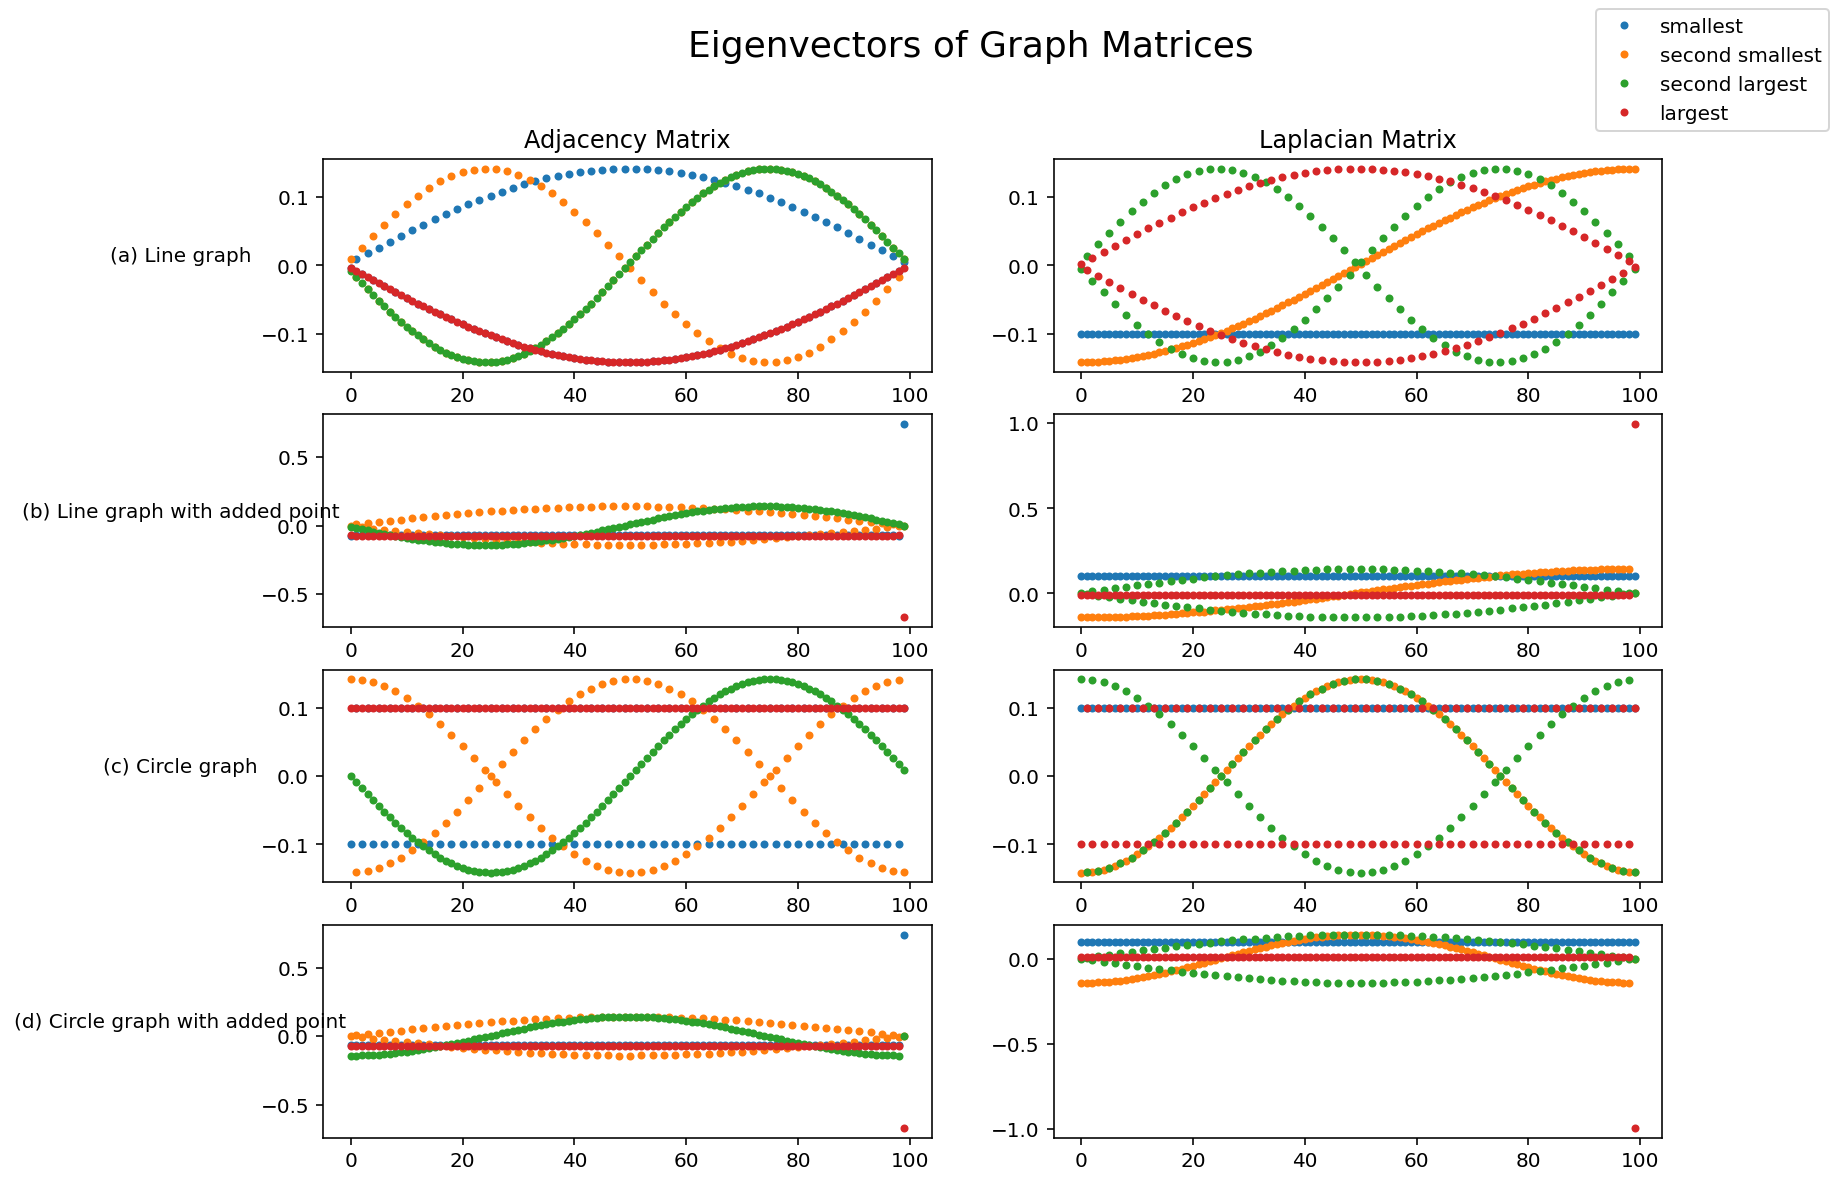

In [6]:
def plot_eigenvectors(n=100):
    eigen_values = []
    fig, axs = plt.subplots(len(GRAPHERS), 2, figsize=(12, 9))
    for (ax_row, (label, grapher)) in zip(axs, GRAPHERS.items()):
        #         ax_row[0].set_title(label)
        g = grapher(100)
        A_eigen_values, A_eigen_vectors = np.linalg.eigh(g.A)
        ax_row[0].plot(A_eigen_vectors[:, 0], ".", label="smallest", linestyle="None")
        ax_row[0].plot(
            A_eigen_vectors[:, 1], ".", label="second smallest", linestyle="None"
        )
        ax_row[0].plot(
            A_eigen_vectors[:, -2], ".", label="second largest", linestyle="None"
        )
        ax_row[0].plot(A_eigen_vectors[:, -1], ".", label="largest", linestyle="None")
        ax_row[0].set_ylabel(label, rotation=0, labelpad=40)

        L_eigen_values, L_eigen_vectors = np.linalg.eigh(g.get_laplacian())
        ax_row[1].plot(L_eigen_vectors[:, 0], ".", label="smallest", linestyle="None")
        ax_row[1].plot(
            L_eigen_vectors[:, 1], ".", label="second smallest", linestyle="None"
        )
        ax_row[1].plot(
            L_eigen_vectors[:, -2], ".", label="second largest", linestyle="None"
        )
        ax_row[1].plot(L_eigen_vectors[:, -1], ".", label="largest", linestyle="None")

        eigen_values.append(
            [label]
            + list(map(
                lambda x: round(x, 4),
                [
                    A_eigen_values[-1],
                    A_eigen_values[-2],
                    A_eigen_values[1],
                    A_eigen_values[0],
                    L_eigen_values[-1],
                    L_eigen_values[-2],
                    L_eigen_values[1],
                    L_eigen_values[0],
                ],
            ))
        )

    axs[0, 0].set_title("Adjacency Matrix")
    axs[0, 1].set_title("Laplacian Matrix")
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels)
    fig.suptitle("Eigenvectors of Graph Matrices", fontsize=18)

    display_table(
        eigen_values,
        "Eigenvalues of Graph Matrices",
        [
            "Graph",
            "A: largest",
            "A: second largest",
            "A: second smallest",
            "A: smallest",
            "L: largest",
            "L: second largest",
            "L: second smallest",
            "L: smallest",
        ],
    )


plot_eigenvectors()

Observations:

1) b) and d) have outlier values at index $n$ because there is one point which is extremely connected; other than the single outlier, the graphs are the same as in a) and c) (they look quite different but it's just because the rest of the plot is squished due to the scaling caused by the outlier).

2) The largest and smallest eigenvectors for c) and d) (the circle graphs) are straight lines because every vertex is (or most vertices are) equally connected. I'm uncertain how to interpret the straight lines in a) and b).

3) There appears to be a pattern of the largest eigenvector being a low frequency sine wave, then the frequency increasing for smaller eigenvalues, then the phase reversing and the frequency going down again for the smallest eigenvectors.

4) The Laplacians each have 1 0-eigenvalue, since each graph is connected.


<div class="custom-assignment-text">

(c) (6 points) For this question, you will consider each of the 4 graphs of part (a) in the case that $n = 100$. For each such $n = 100$ node graph, plot the embedding of the graph onto the eigenvectors corresponding to the 2nd and 3rd smallest eigenvalues of the Laplacian. That is: if $\mathbf{v}_2$ is the second eigenvector and $\mathbf{v}_3$ is the third eigenvector of the Laplacian, create a scatter plot with the points $(\mathbf{v}_2(i), \mathbf{v}_3(i))$ for $i ∈ {1, ... 100}$. Overlay the edges of the graph, i.e. for every pair of points $i, j$, that are connected in the graph $G$, draw an edge between $(\mathbf{v}_2(i), \mathbf{v}_3(i))$ and $(\mathbf{v}_2(j), \mathbf{v}_3(j))$.

</div>

In [7]:
def get_embedding_coordinates(graph, largest=False):
    """Returns (x, y) coordinates of graph vertices embedded in either the two smallest
    (non-zero) or two largest Laplacians"""
    L_eigen_values, L_eigen_vectors = np.linalg.eigh(graph.get_laplacian())
    
    num_zeroes = 0
    for v in L_eigen_values:
        if v < 1e-11:
            num_zeroes += 1
    
    if largest:
        x = L_eigen_vectors[:, -1]
        y = L_eigen_vectors[:, -2]
    else:
        x = L_eigen_vectors[:, num_zeroes]
        y = L_eigen_vectors[:, num_zeroes + 1]
        
    return x, y

def get_embedding_connections(graph, x, y):
    """Return (x_lines, y_lines), giving line coordinates to plot connections
    in the vertices of graph with positions (x, y)"""
    x_lines = []
    y_lines = []
    for i in range(graph.n):
        for j in range(graph.n):
            if i != j:
                if graph.A[i][j]:
                    x_lines.append([x[i],x[j]])
                    y_lines.append([y[i],y[j]])
    
    return x_lines, y_lines

def plot_embedding(ax, graph, largest=False):
    # ensure x and y axes are the same scale
    ax.axis("equal")

    # first plot embedding in Laplacian eigenvectors
    x, y = get_embedding_coordinates(graph, largest)
    ax.scatter(x, y, marker=".")

    # then plot original connections between embedded dots
    x_lines, y_lines = get_embedding_connections(graph, x, y)
    ax.plot(x_lines, y_lines, color="gray", linewidth=1, alpha=.5)
    
    return

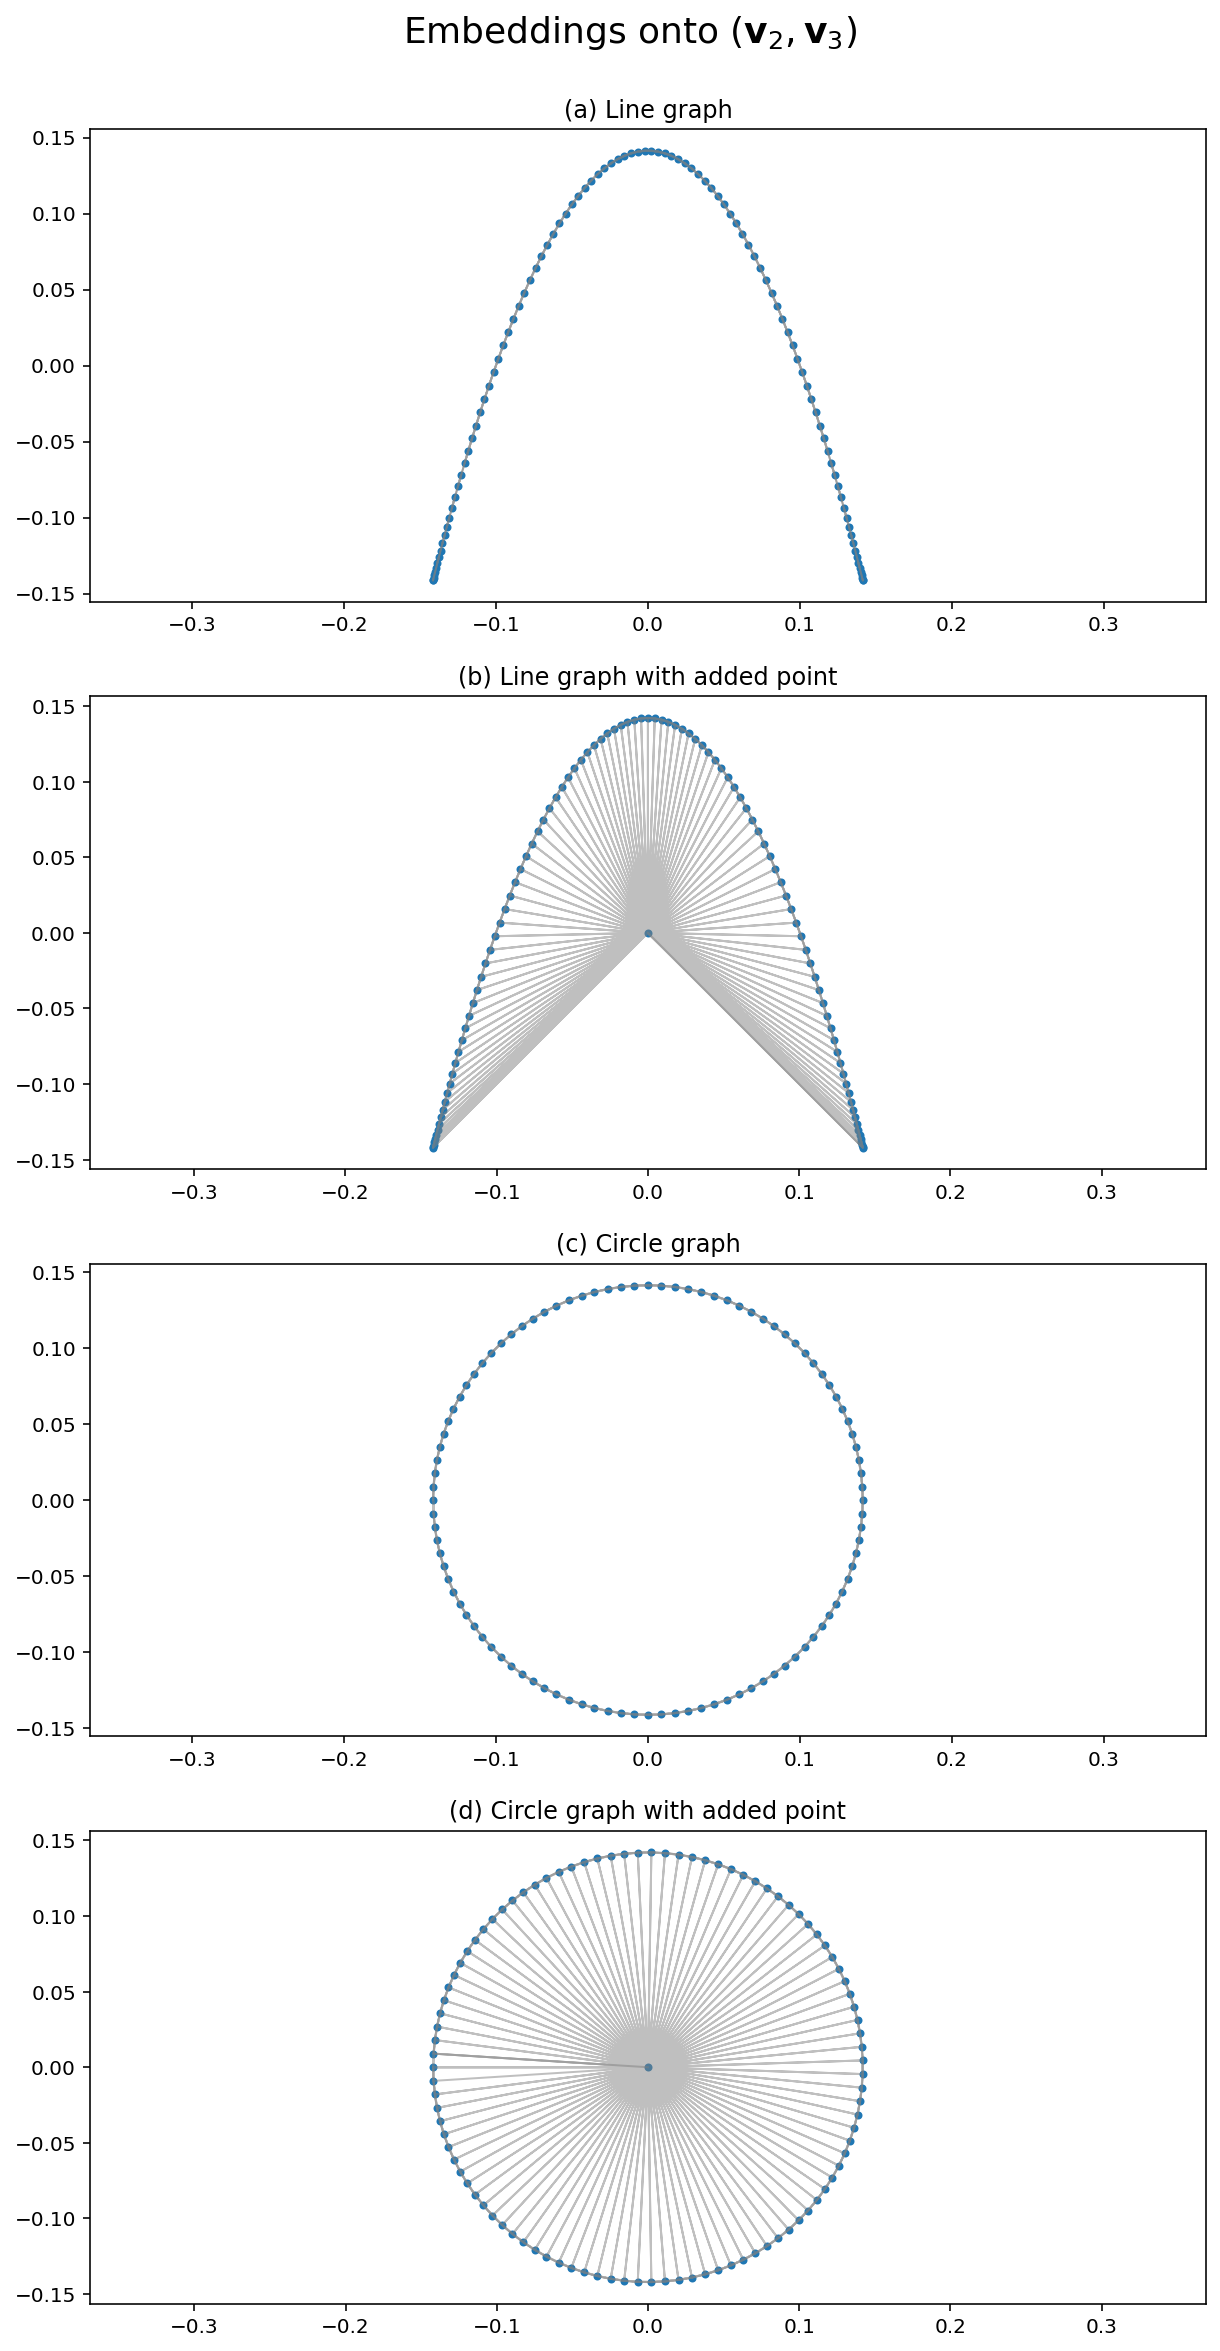

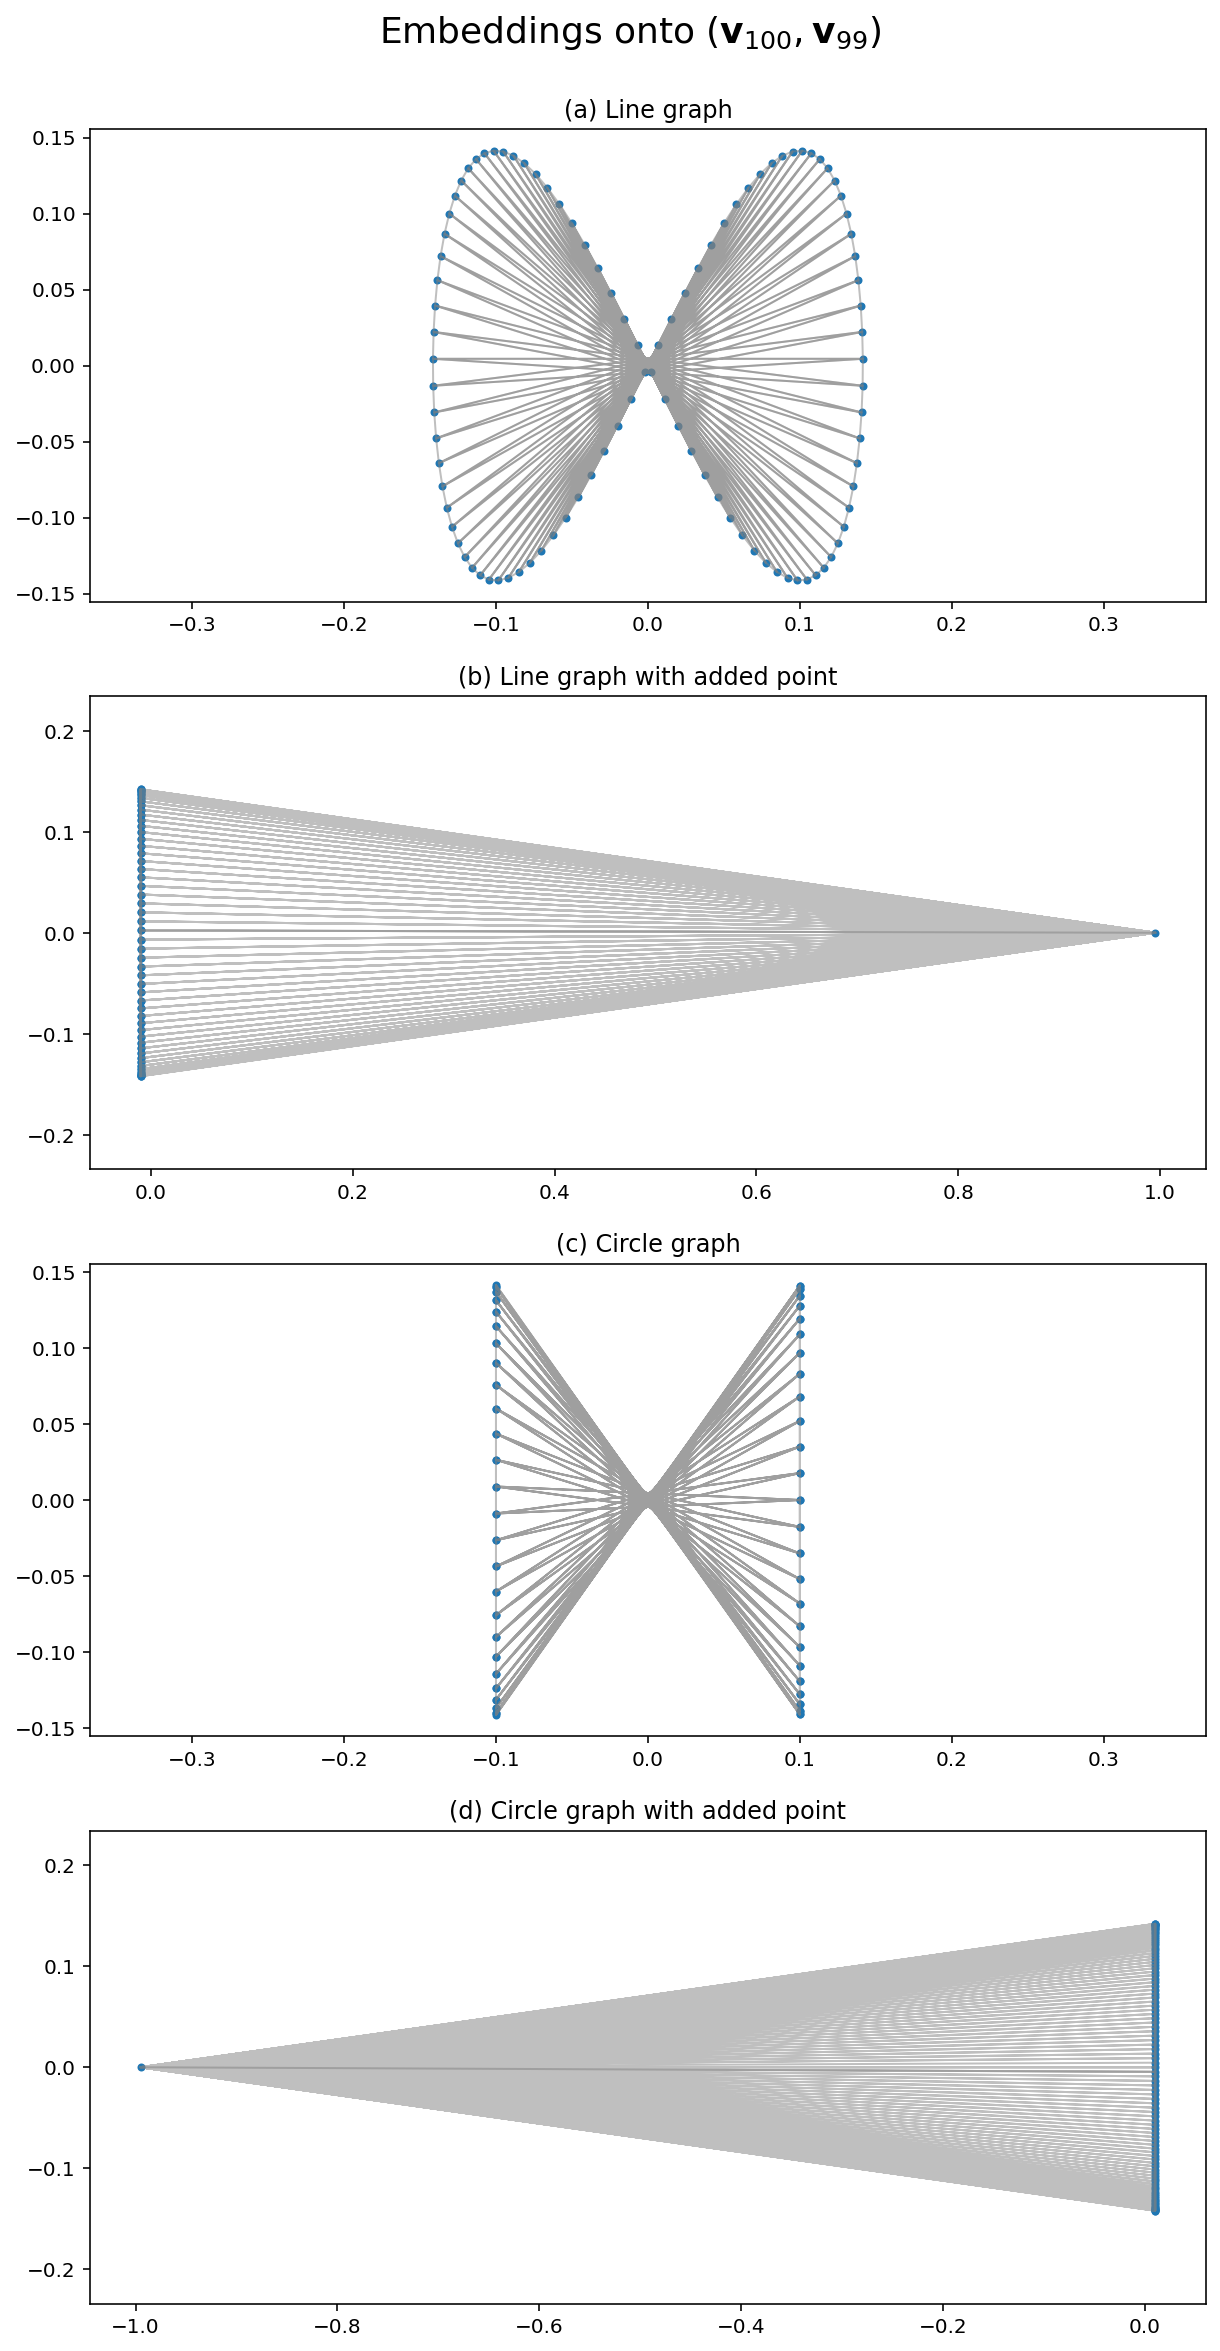

In [8]:
def plot_embeddings_1_c(n=100, largest=False):
    eigen_values = []
    fig, axs = plt.subplots(len(GRAPHERS), 1, figsize=(10,20))
    for (ax_row, (label, grapher)) in zip(axs, GRAPHERS.items()):
        ax_row.set_title(label)
        g = grapher(n)
        plot_embedding(ax_row, g, largest)

    if largest:
        fig.suptitle(f"Embeddings onto $(\mathbf{{v}}_{{{n}}}, \mathbf{{v}}_{{{n-1}}})$", fontsize=18, y=.92)
    else:
        fig.suptitle("Embeddings onto $(\mathbf{v}_2, \mathbf{v}_3)$", fontsize=18, y=.92)

plot_embeddings_1_c()
plot_embeddings_1_c(largest=True)

<div class="custom-assignment-text">

(d) (6 points) Pick 500 random points in the unit square by independently choosing their $x$ and $y$ coordinates uniformly at random from the interval $[0, 1]$. Form a graph by adding an edge between every
pair of points whose Euclidean distance is at most $1/4$. Compute the eigenvectors of the Laplacian
of this graph. Plot the embedding of this graph onto the second and third eigenvectors (i.e. those
corresponding to the 2nd and 3rd smallest eigenvalues). Do not overlay the edges of the graph, just
plot the vertices. For all points in the original graph with x and y coordinates both less than $1/2$, plot their images in a different color. Are these points clustered together in the embedding? Why does this make sense?    

</div>

In [9]:
def random_points_in_square(n=6):
    """sample n random points from unit square, returning a numpy array of shape (n,2).
    Technically the sample spaces are [0,1), not [0,1], but close enough, right?"""
    return np.random.random_sample((n,2))


def point_neighbor_graph(points, max_distance=1/4):
    """Return a graph representing adjacency of points, determined by two points have a maximum
    distance of max_distance"""
    graph = Graph(points.shape[0])
    for i, p_i in enumerate(points):
        for j, p_j in enumerate(points):
            if p_i is not p_j:
                distance = np.linalg.norm(p_i - p_j)
                if distance <= max_distance:
                    graph.add_edge(i,j)

    return graph

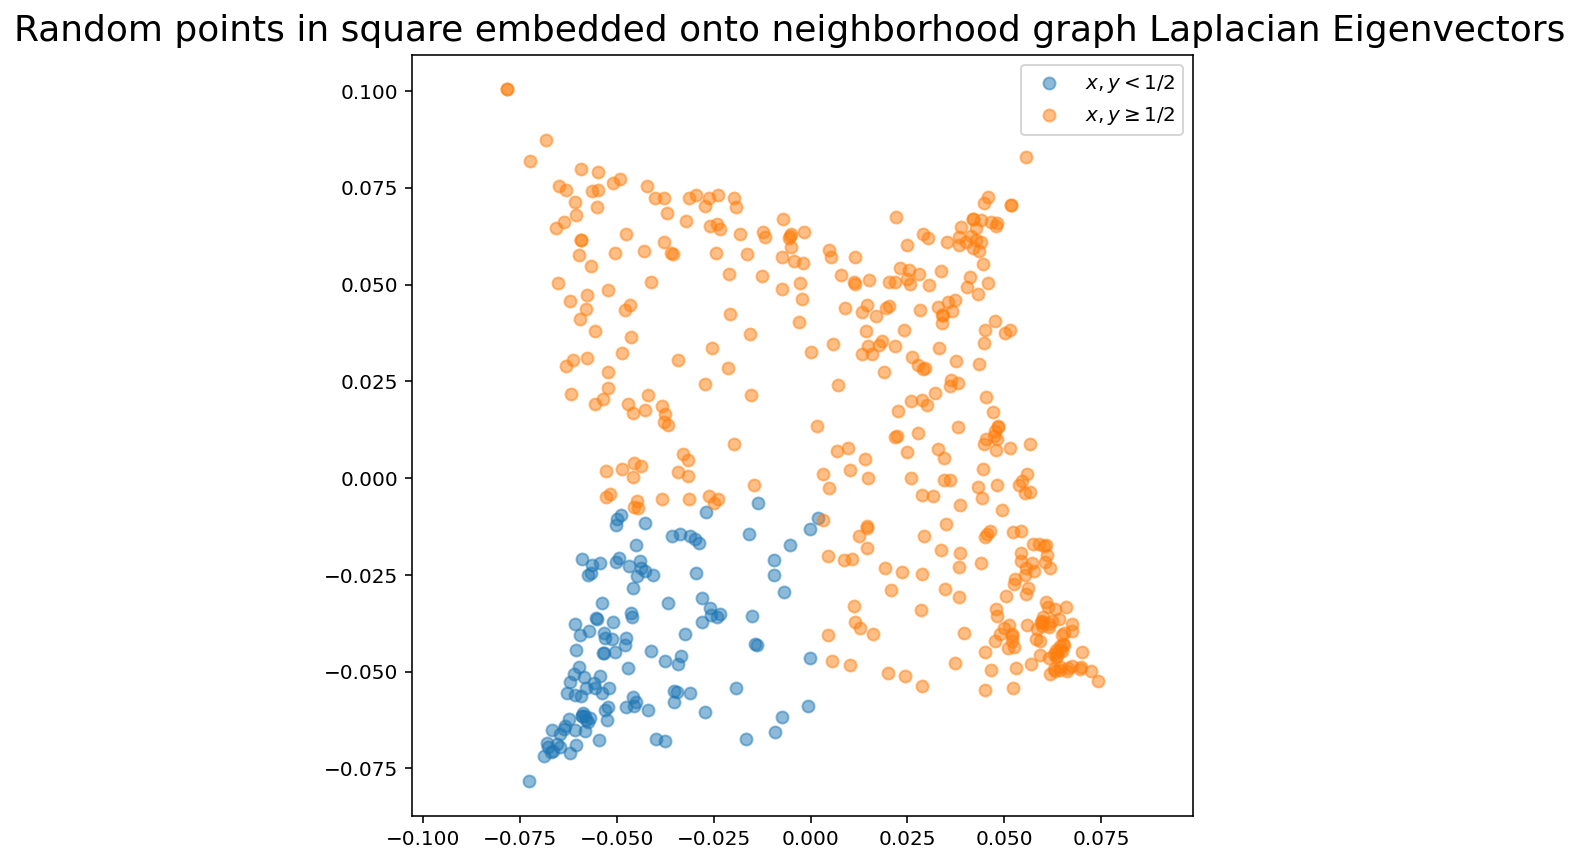

In [10]:
def plot_embedding_1_d(n=6, small_threshold=1/2, max_distance=1/4):
    points = random_points_in_square(n)
    graph = point_neighbor_graph(points)
    small_points = []
    for p in points:
        if p[0] < small_threshold and p[1] < small_threshold:
            small_points.append(True)
        else:
            small_points.append(False)
    small_points = np.array(small_points)
    
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    # ensure x and y axes are the same scale
    ax.axis("equal")

    # first plot embedding in smallest Laplacian eigenvectors
    x, y = get_embedding_coordinates(graph)
    ax.scatter(x[small_points], y[small_points], label="$x,y < 1/2$", alpha=.5)
    ax.scatter(x[~small_points], y[~small_points], label="$x,y \geq 1/2$", alpha=.5)

    ax.legend()
    fig.suptitle("Random points in square embedded onto neighborhood graph Laplacian Eigenvectors", fontsize=18, y=.92)
    
plot_embedding_1_d(500)

The points originally located in the $[0,0]-[1/2,1/2]$ quadrant are indeed located together in the Laplacian embedding. It makes sense for a neighborhood of points to be preserved under this transformation like this, since the smallest Laplacians capture connectedness of points.

<div class="custom-assignment-text">

# Part 2: Finding Friends

## Goal

Experience the magic of graph spectra: use the eigenvectors of a (tiny) subset of the facebook graph to find large, insular groups of friends.

## Description

In this part you will play with a part of the Facebook friend graph to get some appreciation for using spectral methods on a real dataset. The data come from the Stanford Network Analysis Project ([SNAP](http://snap.stanford.edu/)). The file `cs168mp6.csv` is part of the `ego-Facebook` dataset on the SNAP website. Facebook friendships are represented naturally by a node for each person, and an edge if and only if two people are friends on Facebook. In the dataset, each row represents a friendship (edge) between two people (nodes) as identified by unique identifiers.

</div>

In [11]:
import pandas as pd

from cs168.mini_project_6 import load_snap

<div class="custom-assignment-text">

(a) Load in the datafile and make sure that you have 61796 rows and 1495 unique persons.

</div>

In [12]:
SNAP: pd.DataFrame = load_snap()

In [13]:
def _verify_snap():
    assert len(SNAP) == 61796
    assert SNAP[0].unique().shape[0] == 1495

_verify_snap()
ok()

In [87]:
def get_snap_graph(snap):
    g = Graph(snap[0].unique().shape[0])
    for _, row in snap.iterrows():
        g.add_edge(row[0] - 1, row[1] - 1) # data is 1-indexed
    return g

SNAP_GRAPH = get_snap_graph(SNAP)

<div class="custom-assignment-text">

(b) (2 points) Compute the smallest 12 eigenvalues and corresponding eigenvectors of the Laplacian of the
friendship graph.<sup>*</sup> Note: be sure to use the Laplacian of the graph, NOT the adjacency matrix. Print
a list of the smallest 12 eigenvalues, rounded to the nearest 0.001.

<sup>*</sup> Keep in mind that if a graph’s eigenvalue $λ$ has multiplicity $ρ_λ > 1$, then the corresponding eigenvectors are not unique and will depend on the software you use—for this reason your eigenvectors might be different than those of your classmates, though the eigenvalues should be identical up to numerical precision.

</div>

In [15]:
def _report_eigenvalues_2b():
    L_eigen_values, _ = np.linalg.eigh(SNAP_GRAPH.get_laplacian())
    
    values = map(lambda x: round(x, 12), L_eigen_values[0:12])
    display_table([[v] for v in values],"", ["Smallest eigenvalues of the SNAP Laplacian"])
    
_report_eigenvalues_2b()

Smallest eigenvalues of the SNAP Laplacian
-0.0
0.0
0.0
0.0
0.0
0.0
0.028608033239
0.107591305474
0.147805953385
0.162579339425


<div class="custom-assignment-text">

(c) (7 points) How many connected components does this graph have? Justify your answer using the
eigenvalues of the Laplacian. (Keep in mind that your linear algebra package might have some numerical
issues, and a value of $10^{−12}$ should probably be regarded as 0.) Using the eigenvectors, what are the
sizes of the largest and second largest connected components. Explain how you came up with your
answer.

</div>

The smallest 6 eigenvalues are 0, so there are 6 connected components, via theorem 2.1 of lecture 11.

<div class="custom-assignment-text">

(d) (7 points) The conductance of a set of nodes in a graph is a natural measure of how tightly knit/insular that set is, with a lower conductance indicating a more tightly knit set. Given a graph $G = (V, E)$ with adjacency matrix $A$, and a subset of the nodes $S ⊂ V$ , the conductance is defined as:

<center>
$cond(S) = \frac{\sum_{i \in S, j \in V \setminus S, }A_{i,j}}{min(A(S),A(V \setminus S))}$
</center>

where $A(S)$ is the sum of degrees of vertices in set $S$. For example, if $G$ is the circle graph (Figure 1c) and $S$ is $n/2$ consecutive points (for simplicity assume $n$ is a multiple of $2$), then:

<center>
$cond(S) = \frac{\sum_{i \in S, j \in V \setminus S, }A_{i,j}}{min(A(S),A(V \setminus S))} = \frac{2}{2 \cdot n/2} = \frac{2}{n}$
</center>

In the context of a friend graph, the conductance of a set of individuals corresponds to the ratio of
the number of friendships between the outside world and that set, to the total number of friendships
involving that set (so researchers that look for tightly knit groups look for sets with a low conductance). If $cond(S) = 0$, then that set is disconnected from the rest of the graph, and if
$cond(S) = 1$, then there are no internal friendships among members of that set.

Find at least 3 sets, $S_1$, $S_2$, and $S_3$ of people in the friendship graph, such that each set has at least 150 people, and no more than $n/2 ≈ 750$ people, and each set has conductance at most 0.1. The three sets should also be disjoint (nearly disjoint is also okay, though its definitely not okay if one of the sets is a subset of another). For each set, report its size, 10 of its members, and the conductance. Explain how you found each set; in particular, for each set, if you used an eigenvector to identify that set, please include a plot of those eigenvectors, say which eigenvector it is (e.g. the vector corresponding to the 17th smallest eigenvalue) and explain how you identified the set of nodes in the component from that eigenvector (e.g. "This set corresponds to the vertices whose values in the 16th eigenvector are in the range 0.02 ± .001.")

[Hint: If the smallest $s$ eigenvalues are zero, then you should probably look at the eigenvectors corresponding to the $(s + 1)$st smallest and higher eigenvalues. Also, you might not be able to use a single eigenvector to find all three sets—its worth looking at a number of eigenvectors, even the 20th or 30th might still have some nice information about the clusters of friends.]

</div>

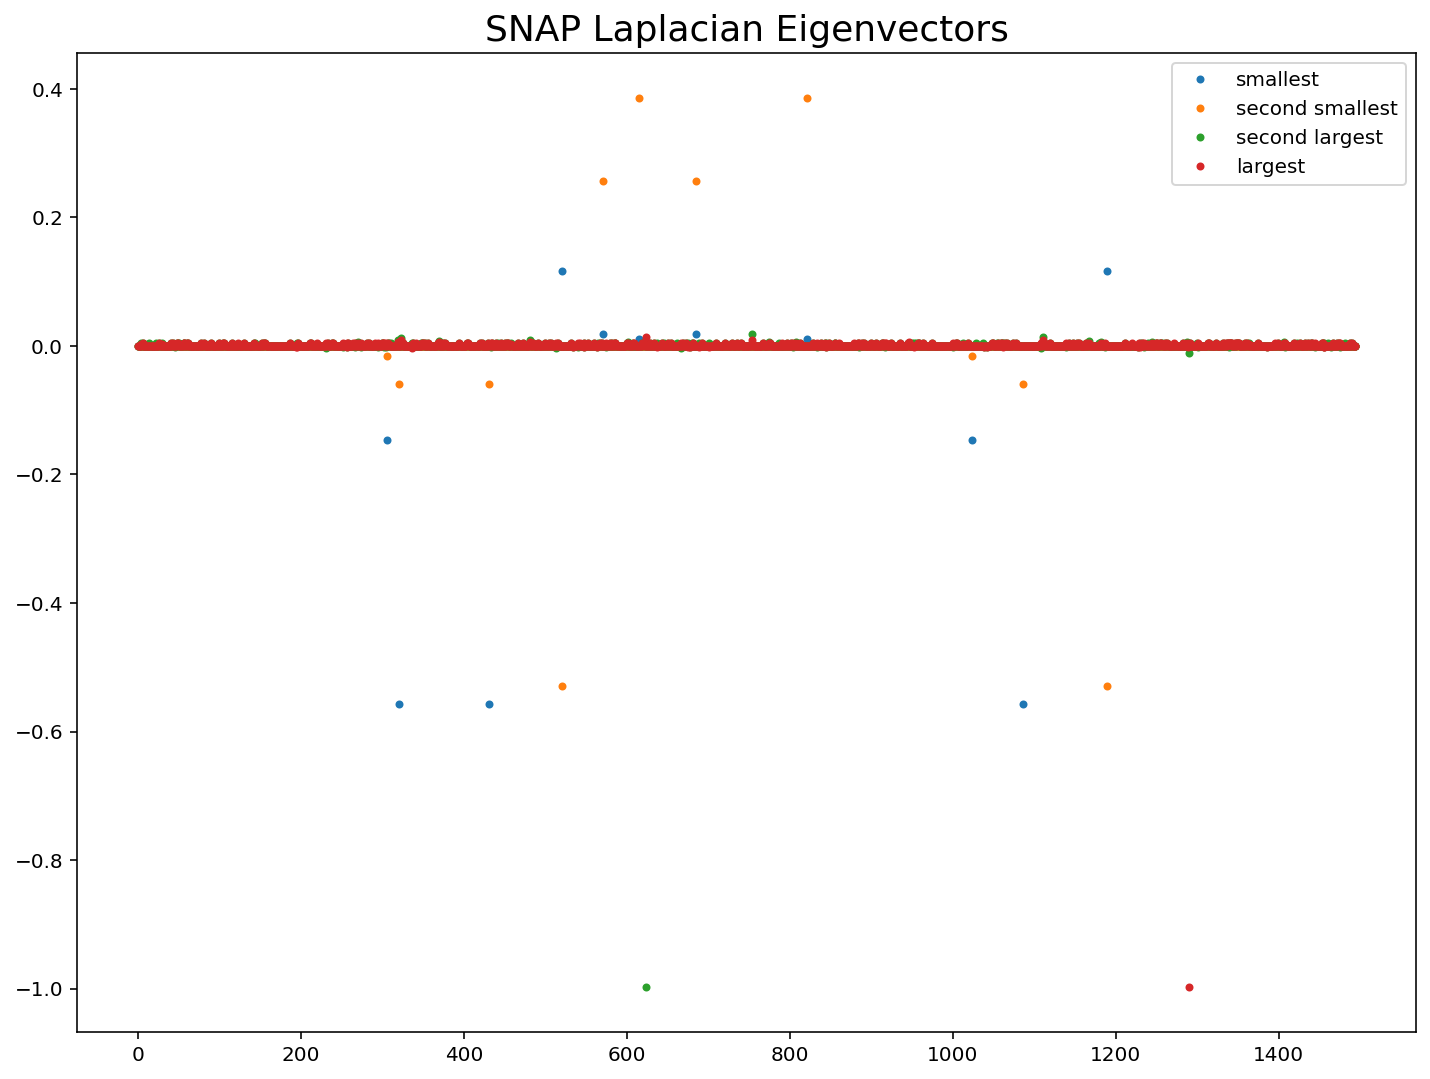

In [16]:
def _plot_snap_eigenvectors():
    fig, ax = plt.subplots(1, figsize=(12, 9))
    
    _, L_eigen_vectors = np.linalg.eigh(SNAP_GRAPH.get_laplacian())
    
    ax.plot(L_eigen_vectors[:, 0], ".", label="smallest", linestyle="None")
    ax.plot(
        L_eigen_vectors[:, 1], ".", label="second smallest", linestyle="None"
    )
    ax.plot(
        L_eigen_vectors[:, -2], ".", label="second largest", linestyle="None"
    )
    ax.plot(L_eigen_vectors[:, -1], ".", label="largest", linestyle="None")
    
    ax.legend()
    ax.set_title("SNAP Laplacian Eigenvectors", fontsize=18)


_plot_snap_eigenvectors()

The scale is quite different between the largest and smallest eigenvector components; other than that, this doesn't really tell me anything.

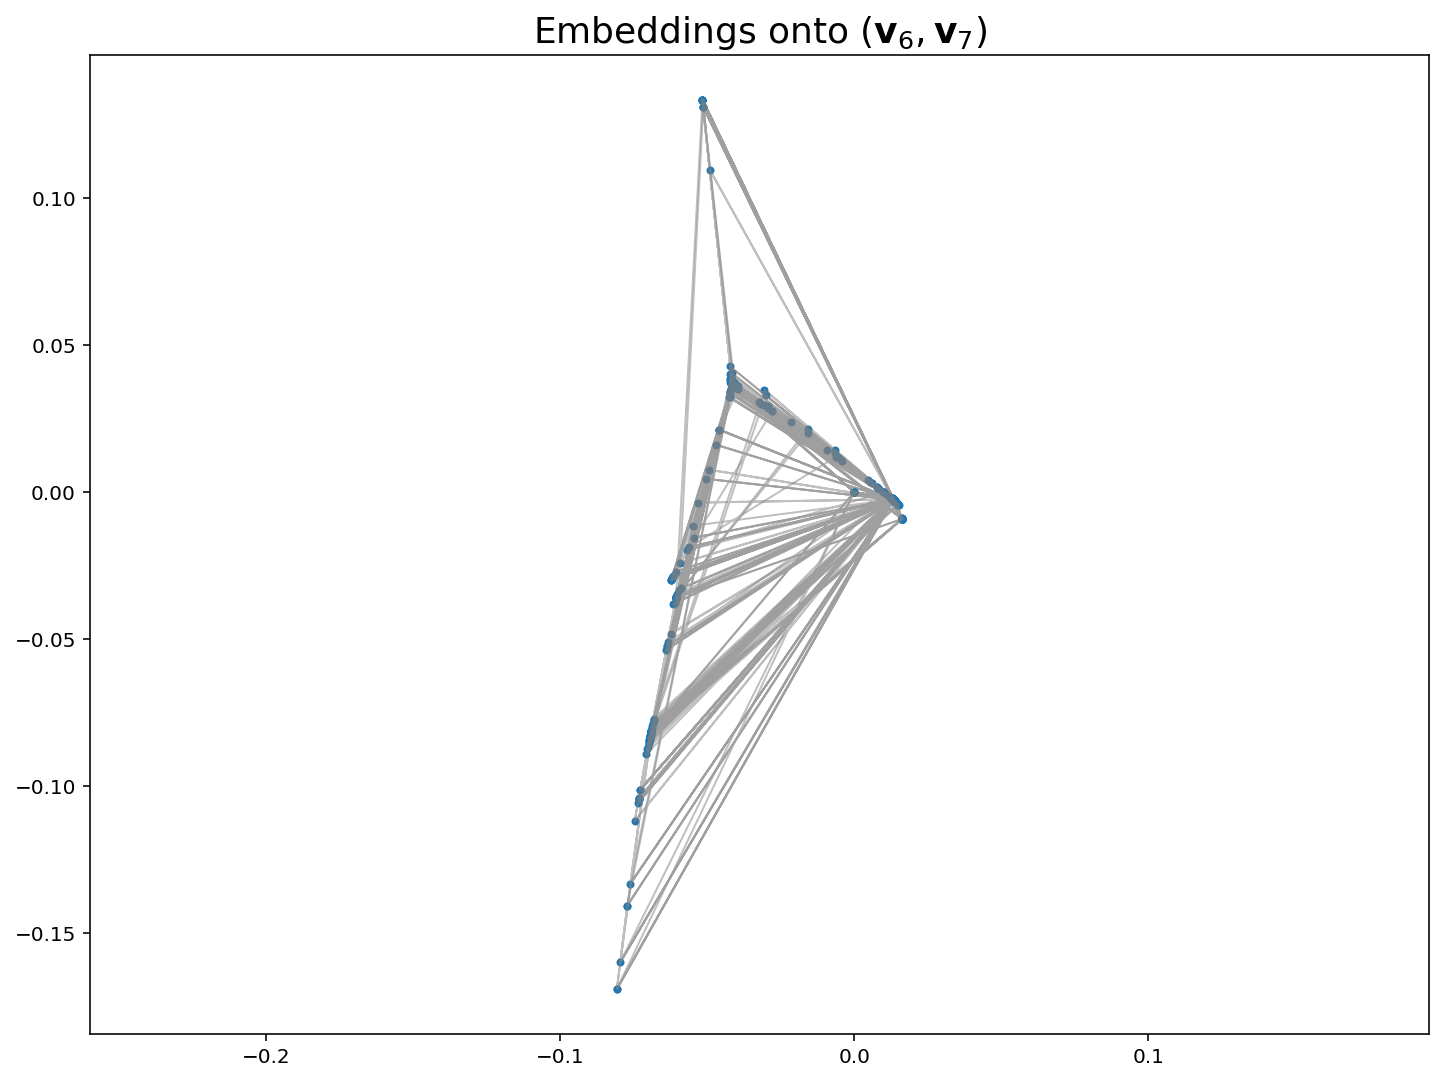

In [17]:
def _plot_snap_embeddings(largest=False):
    eigen_values = []
    fig, ax = plt.subplots(figsize=(12,9))
    
    plot_embedding(ax, SNAP_GRAPH, largest)

    if largest:
        ax.set_title(f"Embeddings onto $(\mathbf{{v}}_{{{SNAP_GRAPH.n}}}, \mathbf{{v}}_{{{SNAP_GRAPH.n-1}}})$", fontsize=18)
    else:
        ax.set_title("Embeddings onto $(\mathbf{v}_6, \mathbf{v}_7)$", fontsize=18)

_plot_snap_embeddings()

The first time I plotted these data, I used $(v_2, v_3)$, and since the corresponding egenvalues are 0 almost all the points clustered at 0. Correctly plotting in $(v_6, v_7)$, we can see that we should be able to zoom in on some clusters.

In [81]:
def _get_snap_cluster():
    x, y = get_embedding_coordinates(SNAP_GRAPH)
    
    # cluster_1 = (y > .1).nonzero() # only 10 :(
    # cluster_1 = (x > .0).nonzero() # 1161
    # cluster_1 = (y < -.05).nonzero() # 57
    cluster_1 = (y < -.02).nonzero() # 84
    
    
    return len(cluster_1[0])
    
_get_snap_cluster()

84

Okay, looks like searching for clusters like that is unwieldy. Let's use an interactive grapher.

In [19]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [21]:
def _display_snap_graph():
    x, y = get_embedding_coordinates(SNAP_GRAPH)
    
    # create a new plot with the toolbar below
    p = figure(width=400, height=400,
               title=None, toolbar_location="below",
               toolbar_sticky=False)

    p.circle(x, y, size=1)

    show(p)

_display_snap_graph()

The dots form a tri-star, with the largest bulk of points gathered in straight lines on the right branch. The straightness of the lines is quite striking.

In [92]:
def _get_snap_cluster():
    x, y = get_embedding_coordinates(SNAP_GRAPH)
    
    cluster_1 = ((x > -.044) & (x < -.038)).nonzero()[0] # 202 elements, conductance of 0.007832898172323759
    print(len(cluster_1))
    print(SNAP_GRAPH.conductance(cluster_1))
    
    cluster_2 = ((y < .03) & (x < -.045)).nonzero()[0] # 95 elements, conductance of 0.0226928895612708
    print(len(cluster_2))
    print(SNAP_GRAPH.conductance(cluster_2))
    
    
    return cluster_1, cluster_2
    
_get_snap_cluster()

202
0.007832898172323759
95
0.0226928895612708


(array([   1,    5,    7,   12,   16,   20,   54,   59,   66,   70,   75,
          83,  110,  128,  132,  139,  148,  149,  150,  151,  157,  159,
         162,  164,  169,  197,  201,  204,  216,  222,  225,  234,  246,
         247,  254,  263,  288,  292,  317,  324,  327,  354,  355,  366,
         371,  387,  389,  395,  397,  402,  403,  414,  415,  417,  437,
         438,  444,  449,  455,  465,  470,  477,  479,  484,  487,  497,
         501,  502,  505,  514,  518,  520,  544,  550,  551,  553,  557,
         562,  572,  578,  583,  587,  589,  590,  592,  607,  610,  634,
         642,  656,  673,  679,  706,  710,  717,  719,  722,  723,  738,
         758,  764,  780,  781,  797,  801,  803,  811,  815,  819,  824,
         830,  840,  841,  850,  857,  866,  870,  872,  875,  876,  895,
         896,  904,  905,  925,  936,  940,  951,  954,  956,  961,  962,
         967,  973,  979,  982,  994,  998, 1007, 1014, 1015, 1018, 1022,
        1030, 1035, 1058, 1068, 1072, 

Choosing the center of the star as one cluster fulfilled the criteria, but the left branch did not have enough elements (though the conductivity was indeed low). It will be difficult to specify square borders in clusters in the right branch since they're at diagonals; if I had a quick way to just draw a lasso around the points I wanted and get the list of indices in Python, I would do that. Instead, we'll try a topological approach.

Next: test with vertices in cluster shown above, or in some others if that fails. If everything fails, try out the topological algorithm.

<div class="custom-assignment-text">

(e) (7 points) Now select a random set of 150 nodes, and compute the conductance of that set. Do the
sets you found in part (d) seem tight-knit compared to this benchmark?

</div>

In [108]:
def random_conductance(graph, sample_size):
    indices = np.random.choice(range(graph.n), sample_size)
    return graph.conductance(indices)
    

for i in range(10):
    print(random_conductance(SNAP_GRAPH, 150))

0.9081568131520709
0.9121746431570109
0.909519934906428
0.917741935483871
0.905224380442063
0.9043506078055022
0.8880357392154126
0.9147807637906648
0.9038591740013541
0.9163078075266804


The randomly-chosen subsets consistently have a conductance around .9, which is way higher than the example subsets we found in problem (d) above.